In [1]:
%matplotlib inline

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import itertools
import pandas as pd
from textblob import TextBlob
import _pickle as cPickle
from pandas import DataFrame
import plotly.figure_factory as ff
from src.model import apriori
import plotly.plotly as py

In [3]:
import sys
project_path = "/media/sarthak/HDD/TUM/courses/sem 3/practical DM/Amazon-Mining"
# make sure to use position 1
sys.path.insert(1, project_path)

## function definitions

In [4]:
# creates a list out of LoL in categories column
def flatten(l):
    return [item for sublist in l for item in sublist]

In [5]:
def get_cat(l):
    return l[1]

In [6]:
def get_helpful(l):
    return l[1]

In [7]:
def get_nonhelpful(l):
    return l[1] - l[0]

In [8]:
def polarity(review_text):
    return TextBlob(review_text).sentiment.polarity

## data loading

In [9]:
from src.data.json_loader import JSONLoader
# file_path corresponds to the file of the .gz file which contains the JSON file. 
product_path = '/media/sarthak/HDD/TUM/courses/sem_3/practical DM/datasets/meta_Electronics.json.gz'
loader = JSONLoader()
product = loader.load_data(product_path)

In [10]:
reviews_path = '/media/sarthak/HDD/TUM/courses/sem_3/practical DM/datasets/reviews_Electronics_5.json.gz'
reviews = loader.load_data(reviews_path)

In [11]:
product.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [12]:
product.shape

(498196, 9)

In [30]:
product[product['asin'] == 'B0071U6WYU']

,asin,imUrl,description,categories,title,price,salesRank,related,brand


In [31]:
product[product['asin'] == 'B0032UP32K']

,asin,imUrl,description,categories,title,price,salesRank,related,brand


In [26]:
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [27]:
reviews.shape

(1689188, 9)

In [28]:
# change LoL to L and get the 2nd category out of it.
product.categories = product.categories.apply(flatten)
product.categories = product.categories.apply(get_cat)

# merging 2 datasets

In [29]:
merged_reviews = reviews.merge(product, on='asin')
merged_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,imUrl,description,categories,title,price,salesRank,related,brand
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...",GPS & Navigation,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...",GPS & Navigation,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...",GPS & Navigation,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...",GPS & Navigation,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...",GPS & Navigation,Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [30]:
merged_reviews.shape

(1689188, 17)

In [31]:
categories = merged_reviews.categories.unique()
categories = categories.tolist()

possible features for clustering:
1. number of products reviewed
2. categories reviewed (1 hot vector)
3. price range
4. num_helpful 
5. num_nonhelpful
6. average rating
7. num_positive reviews
8. num_negative reviews
9. num_categories reviewed
10. Brand? salesRank?

In [32]:
reviewer_df = merged_reviews.groupby(by=['reviewerID'])

In [33]:
len(reviewer_df)

192403

In [34]:
categories

['GPS & Navigation',
 'Computers & Accessories',
 'eBook Readers & Accessories',
 'Accessories & Supplies',
 'Camera & Photo',
 'Portable Audio & Video',
 'Home Audio',
 'Television & Video',
 'Interior Accessories',
 'Accessories',
 'Security & Surveillance',
 'Car & Vehicle Electronics',
 'Cases',
 'Service & Replacement Plans',
 'Electronics Warranties',
 'Tools & Equipment',
 'Cell Phones',
 'Luggage & Travel Gear',
 'Connected Devices',
 'Car Care']

In [19]:
total_categories = len(categories)

In [23]:
index = 0
reviewer_prop = []
for key, item in reviewer_df:
    index += 1
    if index%1000==0:
        print(index)
    categories_list = [0] * total_categories
    ratings_list = [0] * 5 # number of ratings=5
    sentiment_list = [0] * 3
    
    reviewer = reviewer_df.get_group(key) # reviewer is of type Dataframe here where each row depicts one product
    reviewer_id = reviewer['reviewerID'].unique()[0]
    num_products_reviewed = len(reviewer['asin'].unique())
    num_categories = len(reviewer['categories'].unique())
    
    # convert categories to 1-hot-vectors
    categories_reviewed = reviewer['categories'].unique()
    for cat_rev in categories_reviewed:
        categories_list[categories.index(cat_rev)] = 1
    
    ratings = reviewer.overall.unique()
    ratings -= 1
    ratings = list(map(int, ratings))
    ratings_array = np.array(ratings_list)
    ratings_array[ratings] = 1
    ratings_list = list(ratings_array)
    
    num_helpful = sum(reviewer.helpful.apply(get_helpful))
    num_nonhelpful = sum(reviewer.helpful.apply(get_nonhelpful))
    
    # convert polarities to positive, negative and neutral
    polarities = reviewer.reviewText.apply(polarity).values.tolist()
    sentiment_list[0] = sum([polarity <= -0.10 for polarity in polarities])
    sentiment_list[1] = sum([polarity > -0.10 and polarity < 0.10 for polarity in polarities])
    sentiment_list[2] = sum([polarity >= 0.10 for polarity in polarities])  
    
    reviewer_prop.append([reviewer_id, num_products_reviewed, 
                          categories_list, ratings_list, 
                          num_helpful, num_nonhelpful, sentiment_list])

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [28]:
with open('reviewer_data.pkl', 'wb') as output:
    cPickle.dump(reviewer_prop, output, -1)

In [29]:
reviewer_prop[0:5]

[['A000715434M800HLCENK9',
  5,
  [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 0, 1],
  1,
  0,
  [0, 3, 2]],
 ['A00101847G3FJTWYGNQA',
  6,
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  3,
  1,
  [0, 0, 6]],
 ['A00166281YWM98A3SVD55',
  5,
  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  6,
  0,
  [0, 0, 5]],
 ['A0046696382DWIPVIWO0K',
  5,
  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 1],
  3,
  1,
  [0, 1, 4]],
 ['A00472881KT6WR48K907X',
  7,
  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  4,
  0,
  [0, 1, 6]]]

In [4]:
with open('reviewer_data.pkl','rb') as fp:
    reviewers=cPickle.load(fp)

In [5]:
reviewers[0:5]

[['A000715434M800HLCENK9',
  5,
  [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 0, 1],
  1,
  0,
  [0, 3, 2]],
 ['A00101847G3FJTWYGNQA',
  6,
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  3,
  1,
  [0, 0, 6]],
 ['A00166281YWM98A3SVD55',
  5,
  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  6,
  0,
  [0, 0, 5]],
 ['A0046696382DWIPVIWO0K',
  5,
  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 1],
  3,
  1,
  [0, 1, 4]],
 ['A00472881KT6WR48K907X',
  7,
  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 1],
  4,
  0,
  [0, 1, 6]]]

In [11]:
categories = ['GPS & Navigation',
 'Computers & Accessories',
 'eBook Readers & Accessories',
 'Accessories & Supplies',
 'Camera & Photo',
 'Portable Audio & Video',
 'Home Audio',
 'Television & Video',
 'Interior Accessories',
 'Accessories',
 'Security & Surveillance',
 'Car & Vehicle Electronics',
 'Cases',
 'Service & Replacement Plans',
 'Electronics Warranties',
 'Tools & Equipment',
 'Cell Phones',
 'Luggage & Travel Gear',
 'Connected Devices',
 'Car Care']

In [6]:
reviewers_df = DataFrame(reviewers)
#df = df.transpose()
reviewers_df.columns = ['ID', 'products_reviewed', 'categories_reviewed', 'ratings_given', 'num_helpful', 'num_nonhelpful', 'sentiments']

In [7]:
reviewers_df.head()

,ID,products_reviewed,categories_reviewed,ratings_given,num_helpful,num_nonhelpful,sentiments
0,A000715434M800HLCENK9,5,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1]",1,0,"[0, 3, 2]"
1,A00101847G3FJTWYGNQA,6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",3,1,"[0, 0, 6]"
2,A00166281YWM98A3SVD55,5,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",6,0,"[0, 0, 5]"
3,A0046696382DWIPVIWO0K,5,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]",3,1,"[0, 1, 4]"
4,A00472881KT6WR48K907X,7,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",4,0,"[0, 1, 6]"


In [ ]:
db = DBSCAN(eps=5, min_samples=100, metric=ssd.hamming).fit(reviewers_df_categories.as_matrix())
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [8]:
reviewers_df[['negative','neutral', 'positive']] = pd.DataFrame(reviewers_df.sentiments.values.tolist(), index= reviewers_df.index)
reviewers_df.head()

,ID,products_reviewed,categories_reviewed,ratings_given,num_helpful,num_nonhelpful,sentiments,negative,neutral,positive
0,A000715434M800HLCENK9,5,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1]",1,0,"[0, 3, 2]",0,3,2
1,A00101847G3FJTWYGNQA,6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",3,1,"[0, 0, 6]",0,0,6
2,A00166281YWM98A3SVD55,5,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",6,0,"[0, 0, 5]",0,0,5
3,A0046696382DWIPVIWO0K,5,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]",3,1,"[0, 1, 4]",0,1,4
4,A00472881KT6WR48K907X,7,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",4,0,"[0, 1, 6]",0,1,6


In [9]:
reviewers_df[['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']] = pd.DataFrame(reviewers_df.ratings_given.values.tolist(), index= reviewers_df.index)
reviewers_df.head()

,ID,products_reviewed,categories_reviewed,ratings_given,num_helpful,num_nonhelpful,sentiments,negative,neutral,positive,rating_1,rating_2,rating_3,rating_4,rating_5
0,A000715434M800HLCENK9,5,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1]",1,0,"[0, 3, 2]",0,3,2,1,1,1,0,1
1,A00101847G3FJTWYGNQA,6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",3,1,"[0, 0, 6]",0,0,6,0,0,0,1,1
2,A00166281YWM98A3SVD55,5,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",6,0,"[0, 0, 5]",0,0,5,0,0,0,1,1
3,A0046696382DWIPVIWO0K,5,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]",3,1,"[0, 1, 4]",0,1,4,1,0,0,0,1
4,A00472881KT6WR48K907X,7,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",4,0,"[0, 1, 6]",0,1,6,0,0,0,1,1


In [12]:
reviewers_df[categories] = pd.DataFrame(reviewers_df.categories_reviewed.values.tolist(), index= reviewers_df.index)
reviewers_df.head()

,ID,products_reviewed,categories_reviewed,ratings_given,num_helpful,num_nonhelpful,sentiments,negative,neutral,positive,...,Security & Surveillance,Car & Vehicle Electronics,Cases,Service & Replacement Plans,Electronics Warranties,Tools & Equipment,Cell Phones,Luggage & Travel Gear,Connected Devices,Car Care
0,A000715434M800HLCENK9,5,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1]",1,0,"[0, 3, 2]",0,3,2,...,0,0,0,0,0,0,0,0,0,0
1,A00101847G3FJTWYGNQA,6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",3,1,"[0, 0, 6]",0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,A00166281YWM98A3SVD55,5,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",6,0,"[0, 0, 5]",0,0,5,...,0,0,0,0,0,0,0,0,0,0
3,A0046696382DWIPVIWO0K,5,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]",3,1,"[0, 1, 4]",0,1,4,...,0,0,0,0,0,0,0,0,0,0
4,A00472881KT6WR48K907X,7,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",4,0,"[0, 1, 6]",0,1,6,...,0,0,0,0,0,0,0,0,0,0


In [13]:
reviewers_df_trimmed = reviewers_df.drop(['categories_reviewed', 'ratings_given', 'sentiments'], axis=1)

In [14]:
reviewers_df_trimmed.head()

,ID,products_reviewed,num_helpful,num_nonhelpful,negative,neutral,positive,rating_1,rating_2,rating_3,...,Security & Surveillance,Car & Vehicle Electronics,Cases,Service & Replacement Plans,Electronics Warranties,Tools & Equipment,Cell Phones,Luggage & Travel Gear,Connected Devices,Car Care
0,A000715434M800HLCENK9,5,1,0,0,3,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,A00101847G3FJTWYGNQA,6,3,1,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A00166281YWM98A3SVD55,5,6,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A0046696382DWIPVIWO0K,5,3,1,0,1,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A00472881KT6WR48K907X,7,4,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
reviewers_df_trimmed.shape

(192403, 32)

In [16]:
reviewers_matrix = reviewers_df_trimmed.as_matrix(columns=None)

In [17]:
reviewers_matrix[:5]

array([['A000715434M800HLCENK9', 5, 1, 0, 0, 3, 2, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['A00101847G3FJTWYGNQA', 6, 3, 1, 0, 0, 6, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['A00166281YWM98A3SVD55', 5, 6, 0, 0, 0, 5, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['A0046696382DWIPVIWO0K', 5, 3, 1, 0, 1, 4, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['A00472881KT6WR48K907X', 7, 4, 0, 0, 1, 6, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [18]:
reviewers_df_categories = reviewers_df_trimmed[categories]

In [19]:
reviewers_df_categories.head()

,GPS & Navigation,Computers & Accessories,eBook Readers & Accessories,Accessories & Supplies,Camera & Photo,Portable Audio & Video,Home Audio,Television & Video,Interior Accessories,Accessories,Security & Surveillance,Car & Vehicle Electronics,Cases,Service & Replacement Plans,Electronics Warranties,Tools & Equipment,Cell Phones,Luggage & Travel Gear,Connected Devices,Car Care
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
reviewers_df_categories.as_matrix()[0]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(reviewers_df_categories.as_matrix())

In [21]:
kmeans.labels_

array([8, 0, 0, ..., 6, 7, 5], dtype=int32)

In [42]:
clusters = []
for c_id in range(10):
    cluster_indices = np.where(kmeans.labels_ == c_id)
    cluster = reviewers_df_categories.as_matrix()[cluster_indices]
    clusters.append(np.sum(cluster, axis=0))

In [43]:
clusters[0]

array([ 1043, 31594,  2517,     0,  6220, 16448,  2388,  2022,     3,
        4551,   665,  3867,   860,    55,   554,    17,    12,    20,
           6,    17])

In [39]:
import scipy

In [44]:

import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=categories,
            y=clusters[0]
    )]

py.iplot(data, filename='basic-bar')

In [45]:
data = [go.Bar(
            x=categories,
            y=clusters[1]
    )]

py.iplot(data, filename='basic-bar')

In [46]:
data = [go.Bar(
            x=categories,
            y=clusters[2]
    )]

py.iplot(data, filename='basic-bar')

In [47]:
data = [go.Bar(
            x=categories,
            y=clusters[3]
    )]

py.iplot(data, filename='basic-bar')

In [48]:
data = [go.Bar(
            x=categories,
            y=clusters[4]
    )]

py.iplot(data, filename='basic-bar')

In [49]:
data = [go.Bar(
            x=categories,
            y=clusters[6]
    )]

py.iplot(data, filename='basic-bar')

In [50]:
data = [go.Bar(
            x=categories,
            y=clusters[7]
    )]

py.iplot(data, filename='basic-bar')

In [51]:
data = [go.Bar(
            x=categories,
            y=clusters[8]
    )]

py.iplot(data, filename='basic-bar')

In [53]:
data = [go.Bar(
            x=categories,
            y=clusters[9]
    )]

py.iplot(data, filename='basic-bar')

In [24]:
import collections

In [25]:
num_samples = collections.Counter(kmeans.labels_)
print(num_samples)

Counter({0: 32200, 8: 29665, 2: 27151, 6: 21120, 5: 16897, 9: 16067, 4: 16056, 3: 12910, 1: 11232, 7: 9105})


In [26]:
import numpy as np
from kmodes.kmodes import KModes

In [81]:
km = KModes(n_clusters=10, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(reviewers_df_categories.as_matrix())

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 13264, cost: 216001.0
Run 1, iteration: 2/100, moves: 0, cost: 216001.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 14935, cost: 200176.0
Run 2, iteration: 2/100, moves: 0, cost: 200176.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 17583, cost: 200299.0
Run 3, iteration: 2/100, moves: 0, cost: 200299.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13713, cost: 196362.0
Run 4, iteration: 2/100, moves: 4773, cost: 194351.0
Run 4, iteration: 3/100, moves: 264, cost: 194351.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 32772, cost: 197954.0
Run 5, iteration: 2/100, moves: 13771, cost: 197954.0
Best run was number 4

In [82]:
len(clusters)

192403

In [83]:
modes = []
for c_id in range(10):
    cluster_indices = np.where(clusters == c_id)
    cluster = reviewers_df_categories.as_matrix()[cluster_indices]
    modes.append(np.sum(cluster, axis=0))

In [119]:
data = [go.Bar(
            x=categories,
            y=modes[0]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 1',
    'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [120]:
data = [go.Bar(
            x=categories,
            y=modes[1]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 2',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [121]:
data = [go.Bar(
            x=categories,
            y=modes[2]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 3',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [122]:
data = [go.Bar(
            x=categories,
            y=modes[3]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 4',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [123]:
data = [go.Bar(
            x=categories,
            y=modes[4]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 5',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [124]:
data = [go.Bar(
            x=categories,
            y=modes[5]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 6',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [125]:
data = [go.Bar(
            x=categories,
            y=modes[6]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 7',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [126]:
data = [go.Bar(
            x=categories,
            y=modes[7]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 8',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [127]:
data = [go.Bar(
            x=categories,
            y=modes[8]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 9',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [128]:
data = [go.Bar(
            x=categories,
            y=modes[9]
    )]
layout = {
  'xaxis': {'title': 'categories'},
  'yaxis': {'title': 'number of reviews'},
  'title': 'cluster analysis: cluster 10',
        'width':800,
    'height':400
};

py.iplot({'data': data, 'layout': layout}, filename='basic-bar')

In [107]:
reviewers_df.head()

,ID,products_reviewed,categories_reviewed,ratings_given,num_helpful,num_nonhelpful,sentiments,negative,neutral,positive,...,Security & Surveillance,Car & Vehicle Electronics,Cases,Service & Replacement Plans,Electronics Warranties,Tools & Equipment,Cell Phones,Luggage & Travel Gear,Connected Devices,Car Care
0,A000715434M800HLCENK9,5,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1]",1,0,"[0, 3, 2]",0,3,2,...,0,0,0,0,0,0,0,0,0,0
1,A00101847G3FJTWYGNQA,6,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",3,1,"[0, 0, 6]",0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,A00166281YWM98A3SVD55,5,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",6,0,"[0, 0, 5]",0,0,5,...,0,0,0,0,0,0,0,0,0,0
3,A0046696382DWIPVIWO0K,5,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]",3,1,"[0, 1, 4]",0,1,4,...,0,0,0,0,0,0,0,0,0,0
4,A00472881KT6WR48K907X,7,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1]",4,0,"[0, 1, 6]",0,1,6,...,0,0,0,0,0,0,0,0,0,0


In [112]:
reviewed_helpful = reviewers_df[['products_reviewed', 'num_helpful']]
reviewed_helpful

,products_reviewed,num_helpful
0,5,1
1,6,3
2,5,6
3,5,3
4,7,4
5,9,0
6,7,2
7,6,1
8,6,0
9,6,1


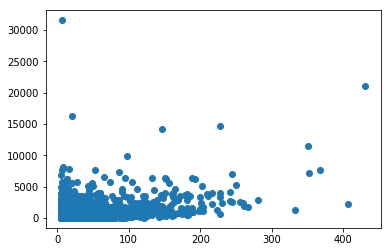

In [114]:
plt.scatter(x=reviewed_helpful.products_reviewed.as_matrix(), y=reviewed_helpful.num_helpful.as_matrix())